In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
import numpy as np


from dataset import train_split_files

from utils import clear_memory

from config import (
    DATA_DIR,
    MODEL_PATH,
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    EPOCHS,
    BATCH_SIZE,
    LR,
    SPLIT,
	UNROLL_STEPS
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torch.utils.data import Dataset
import json
from create_structured_grids import create_structured_grids

DATA_DIR = "data/fluid-openfoam/"
X_CELLS = 128
Y_CELLS = 64
T_STRIDE = 20

class CFDDataset(Dataset):
    def __init__(self, file_paths, x_cells=X_CELLS, y_cells=Y_CELLS, t_stride=T_STRIDE):
        self.data = []
        self.file_paths = file_paths
        self.x_cells = x_cells
        self.y_cells = y_cells
        self.t_stride = t_stride
        self._load_data()

    def _load_data(self):
        for file_path in self.file_paths:
            data = np.load(file_path)
            params_str = data['parameters'].item()
            params = json.loads(params_str)
            domain = params['domain']
            viscosity = params['kinematic_viscosity']
            width = domain['width']
            height = domain['height']
            internal_coords = data['internal_coordinates']
            boundary_coords = data['boundary_coordinates']
            internal_values = data['Solver-Mesh-2D-Internal']
            boundary_values = data['Solver-Mesh-2D-Boundaries']
            timesteps = internal_values.shape[0]

            domain['h_cells'] = self.x_cells
            domain['v_cells'] = self.y_cells
            domain['dx'] = domain['width'] / domain['h_cells']
            domain['dy'] = domain['height'] / domain['v_cells']

            internal_grid, boundary_grid = create_structured_grids(
                internal_coords, internal_values, boundary_coords, boundary_values, domain
            )

            internal_mask = ~np.isnan(internal_grid[:, :, :, 0:1])
            boundary_mask = ~np.isnan(boundary_grid[:, :, :, 0:1])

            internal_grid = np.nan_to_num(internal_grid, nan=0.0)
            boundary_grid = np.nan_to_num(boundary_grid, nan=0.0)

            viscosity_channel = np.full((timesteps, self.y_cells, self.x_cells, 1), viscosity)
            width_channel = np.full((timesteps, self.y_cells, self.x_cells, 1), width)
            height_channel = np.full((timesteps, self.y_cells, self.x_cells, 1), height)

            data_concatenated = np.concatenate([
                internal_grid,      # 2 channels
                boundary_grid,      # 2 channels
                internal_mask,      # 1 channel
                boundary_mask,      # 1 channel
                viscosity_channel,  # 1 channel
                width_channel,      # 1 channel
                height_channel      # 1 channel
            ], axis=-1, dtype=np.float32)

            for t in range(0, timesteps - self.t_stride, self.t_stride):
                self.data.append((data_concatenated[t], data_concatenated[t + self.t_stride]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        x = np.transpose(x, (2, 0, 1))
        y = np.transpose(y, (2, 0, 1))
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

DATA_DIR = "../data/fluid-openfoam/"
SPLIT = .8
train_files, val_files = train_split_files(data_dir=DATA_DIR, split=SPLIT)
train_files = train_files
val_files = val_files
train_dataset = CFDDataset(file_paths=train_files)
val_dataset = CFDDataset(file_paths=val_files)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Found 99 simulations.
Splitting into 79 training and 20 validation files.


In [3]:
example_params_str = "{'domain': {'x_min': 0.0, 'y_min': 0.0, 'width': 6.0, 'height': 3.0}, 'obstacle': {'x_min': 2.25, 'x_max': 3.375, 'height': 1.5}, 'inlet_velocity': [4.7, 0, 0], 'kinematic_viscosity': 0.08286427728546843, 'simulation_control': {'endTime': 5.0, 'deltaT': 0.01, 'writeInterval': 20}, 'grading': {'h1_cells': 48, 'h2_cells': 24, 'h3_cells': 56, 'v1_cells': 32, 'v2_cells': 32}}"

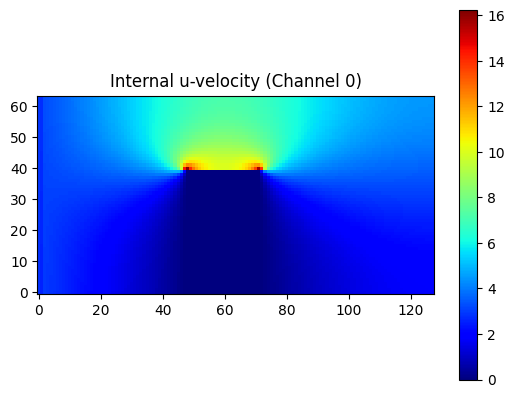

In [4]:
# In[4]:
#sample the train_loader
sample = next(iter(train_loader))
x, y = sample

u_velocity_field = x[0, 0, :, :] 

plt.imshow(u_velocity_field.numpy(), cmap='jet', origin="lower")
plt.colorbar()
plt.title("Internal u-velocity (Channel 0)")
plt.show()

In [5]:
# # In[5]:
# from IPython.display import clear_output
# import time

# # Again, ensure batch_size=1 and shuffle=False
# test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# # Create a figure and axes once, outside the loop
# fig, ax = plt.subplots(figsize=(10, 5))

# for timestep_index, sample in enumerate(test_loader):
#     x, y = sample

#     # --- The Fix ---
#     # Select the u-velocity (channel 0) and v-velocity (channel 1)
#     # x[0] removes the batch dimension
#     u_velocity = x[0, 0, :, :].numpy()
#     v_velocity = x[0, 1, :, :].numpy()

#     # Now calculate the magnitude
#     field_to_plot = np.sqrt(u_velocity**2 + v_velocity**2)

#     # Clear the previous plot from the output cell
#     clear_output(wait=True)

#     # Clear the previous data from the axes
#     ax.clear()

#     # Draw the new image
#     im = ax.imshow(field_to_plot, cmap='coolwarm', origin="lower")

#     # We need to re-add the title each time
#     ax.set_title(f"Velocity Magnitude (Timestep: {timestep_index})")

#     # Display the updated plot
#     display(fig)

# # Close the figure at the end to clean up
# plt.close(fig)

In [6]:
from model import ResidualUNet

# Input: 2 vel + 2 bnd + 2 masks + 3 params = 9 channels
# Model predicts residual for: 2 velocity channels
model = ResidualUNet(in_channels=9, field_channels=2).to(device)

sample_x, sample_y = next(iter(train_loader))
sample_x = sample_x.to(device)
sample_y = sample_y.to(device)
print(f"Input shape from DataLoader: {sample_x.shape}")
print(f"Target shape from DataLoader: {sample_y.shape}")

with torch.no_grad():
    predicted_y = model(sample_x)
print(f"Model output shape: {predicted_y.shape}")
assert predicted_y.shape == sample_y.shape
print("\nModel test successful! Shapes match.")

Input shape from DataLoader: torch.Size([32, 9, 64, 128])
Target shape from DataLoader: torch.Size([32, 9, 64, 128])
Model output shape: torch.Size([32, 9, 64, 128])

Model test successful! Shapes match.


In [7]:
MODEL_SAVE_PATH = "models/ResidualUNet_CFD.pth"

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

LR = 1e-3
EPOCHS = 50
BATCH_SIZE = 16

print(f"Configuration:")
print(f"  Device: {device}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LR}")
print(f"  Epochs: {EPOCHS}")
print(f"  Model Save Path: {MODEL_SAVE_PATH}")

Configuration:
  Device: cuda
  Batch Size: 16
  Learning Rate: 0.001
  Epochs: 50
  Model Save Path: models/ResidualUNet_CFD.pth


In [8]:
def masked_mse_loss(pred, target):
    # The internal fluid mask is the 5th channel (index 4)
    valid_mask = target[:, 4:5, :, :] 

    # We only compute loss on the first 2 channels (u, v internal velocity)
    pred_fields = pred[:, :2, :, :]
    target_fields = target[:, :2, :, :]
    
    squared_error = (pred_fields - target_fields)**2
    masked_squared_error = squared_error * valid_mask
    
    # Calculate the mean loss only over the number of valid pixels
    loss = masked_squared_error.sum() / (valid_mask.sum() + 1e-8)
    return loss

In [ ]:
def scaled_masked_mse_loss(pred, target):
    """
    Calculates MSE loss scaled by the magnitude of the target velocity field.
    """
    # The internal fluid mask is the 5th channel (index 4)
    valid_mask = target[:, 4:5, :, :] 

    # We compute loss on the first 2 channels (u, v internal velocity)
    pred_fields = pred[:, :2, :, :]
    target_fields = target[:, :2, :, :]
    
    squared_error = (pred_fields - target_fields)**2
    masked_squared_error = squared_error * valid_mask
    
    # --- Loss Scaling ---
    target_norm_sq = (target_fields**2) * valid_mask
    scaling_factor = target_norm_sq.mean() + 1e-8
    
    loss = masked_squared_error.sum() / (valid_mask.sum() + 1e-8)
    normalized_loss = loss / scaling_factor
    
    return normalized_loss

In [10]:
def training_loop(criterion, optimizer, scheduler, model, train_loader, val_loader, device, epochs):
    best_val_loss = float("inf")
    best_model_wts = None
    loss_history = {"train": [], "val": []}
    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                val_loss += criterion(y_pred, y).item()
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"--> New best model found at epoch {epoch+1} with val loss {best_val_loss:.6f}")
        current_lr = optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.6f} | "
            f"Val Loss: {avg_val_loss:.6f} | "
            f"LR: {current_lr:.8f}"
        )
        loss_history["train"].append(avg_train_loss)
        loss_history["val"].append(avg_val_loss)
        scheduler.step()
    if best_model_wts:
        print(f"\nLoading best model weights with validation loss: {best_val_loss:.6f}")
        model.load_state_dict(best_model_wts)
    print("Finished training.")
    return loss_history

# Re-instantiate model, criterion, and optimizer
model = ResidualUNet(in_channels=9, field_channels=2).to(device)
# criterion = masked_mse_loss
criterion = scaled_masked_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

if not os.path.exists(MODEL_SAVE_PATH):
    loss_history = training_loop(criterion, optimizer, scheduler, model, train_loader, val_loader, device, epochs=EPOCHS)
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nBest model saved to {MODEL_SAVE_PATH}")
else:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    model.eval()
    print(f"Model loaded from {MODEL_SAVE_PATH}")
    loss_history = None

Starting training...
--> New best model found at epoch 1 with val loss 0.020982
Epoch 1/50 | Train Loss: 0.022279 | Val Loss: 0.020982 | LR: 0.00100000
--> New best model found at epoch 2 with val loss 0.015482
Epoch 2/50 | Train Loss: 0.017736 | Val Loss: 0.015482 | LR: 0.00099901
--> New best model found at epoch 3 with val loss 0.012172
Epoch 3/50 | Train Loss: 0.015466 | Val Loss: 0.012172 | LR: 0.00099606
--> New best model found at epoch 4 with val loss 0.010528
Epoch 4/50 | Train Loss: 0.014971 | Val Loss: 0.010528 | LR: 0.00099114
--> New best model found at epoch 5 with val loss 0.009808
Epoch 5/50 | Train Loss: 0.013214 | Val Loss: 0.009808 | LR: 0.00098429
Epoch 6/50 | Train Loss: 0.011851 | Val Loss: 0.010734 | LR: 0.00097553
Epoch 7/50 | Train Loss: 0.012080 | Val Loss: 0.014936 | LR: 0.00096489
--> New best model found at epoch 8 with val loss 0.009723
Epoch 8/50 | Train Loss: 0.011469 | Val Loss: 0.009723 | LR: 0.00095241
Epoch 9/50 | Train Loss: 0.013572 | Val Loss: 0.0

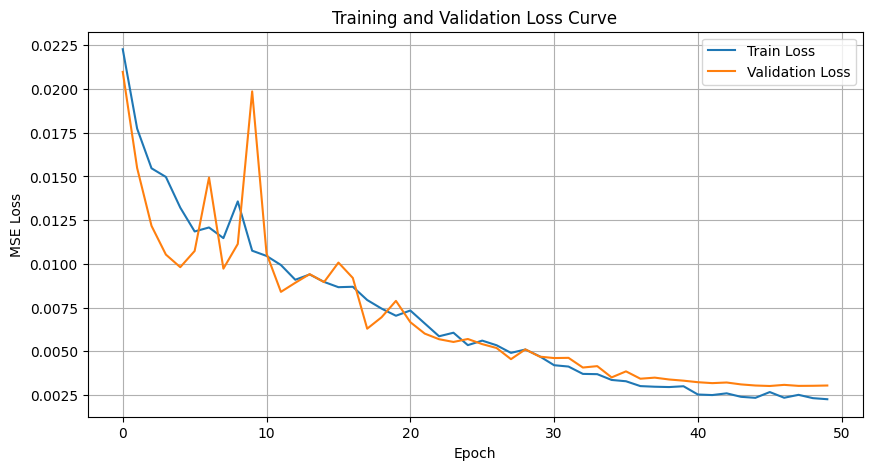

In [14]:
if loss_history:
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history["train"], label="Train Loss")
    plt.plot(loss_history["val"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Validation Loss Curve")
    plt.grid(True)
    plt.show()

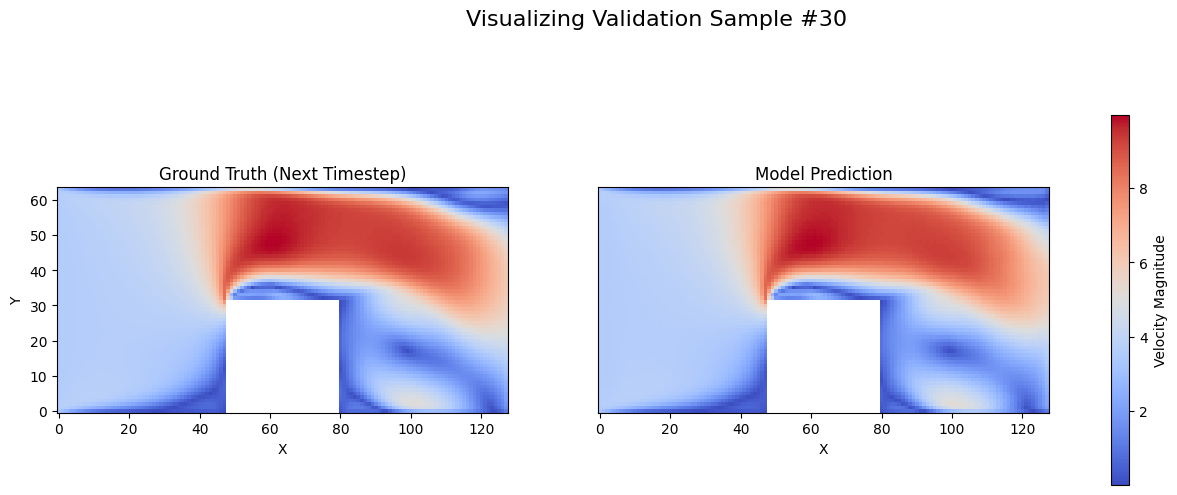

In [ ]:
sample_idx_to_visualize = 30

model.eval()

if sample_idx_to_visualize < len(val_dataset):
    input_x_raw, ground_truth_y_raw = val_dataset[sample_idx_to_visualize]

    # The model expects a batch, so we add a batch dimension (N=1).
    # Shape goes from (C, H, W) to (1, C, H, W).
    input_x = input_x_raw.unsqueeze(0).to(device)

    # --- 3. Get the Model's Prediction ---
    with torch.no_grad():
        predicted_y = model(input_x)

    ground_truth_y_np = ground_truth_y_raw.numpy()
    predicted_y_np = predicted_y.cpu().squeeze(0).numpy() # squeeze(0) removes the batch dim

    gt_u = ground_truth_y_np[0, :, :]
    gt_v = ground_truth_y_np[1, :, :]
    gt_magnitude = np.sqrt(gt_u**2 + gt_v**2)

    pred_u = predicted_y_np[0, :, :]
    pred_v = predicted_y_np[1, :, :]
    pred_magnitude = np.sqrt(pred_u**2 + pred_v**2)

    mask = ground_truth_y_np[4, :, :] # Mask is channel 4
    gt_magnitude[mask == 0] = np.nan
    pred_magnitude[mask == 0] = np.nan


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    vmin = np.nanmin([gt_magnitude, pred_magnitude])
    vmax = np.nanmax([gt_magnitude, pred_magnitude])

    # Plot Ground Truth
    im1 = axes[0].imshow(gt_magnitude, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title('Ground Truth (Next Timestep)')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    # Plot Model Prediction
    im2 = axes[1].imshow(pred_magnitude, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
    axes[1].set_title('Model Prediction')
    axes[1].set_xlabel('X')
    axes[1].set_yticks([])

    fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.8, label='Velocity Magnitude')
    plt.suptitle(f'Visualizing Validation Sample #{sample_idx_to_visualize}', fontsize=16)
    plt.show()

else:
    print(f"Error: Sample index {sample_idx_to_visualize} is out of bounds for the validation set (size: {len(val_dataset)}).")
    print("Please choose an index between 0 and {}.".format(len(val_dataset) - 1))